# 3. Segmenting and Clustering Neighborhoods in Toronto City

In [1]:
#for geocoding
from geopy.geocoders import Nominatim

#for making http requests
import requests

#for reading and preprocessing csv
import pandas as pd

#for mapping
import folium

#for numerical functions
import numpy as np

#for clustering functions
from sklearn.cluster import KMeans

#for graph plotting
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

## Read the csv file and geocode locations using geopy

### Read the csv file created earlier and clean the data to remove unwanted columns and special charatcters

In [2]:
df = pd.read_csv("toronto_coords.csv")

#remove the unwanted column
df = df.drop("Unnamed: 0", axis = 1)

#remove the special characters from neighbourhood names
df = df.replace({"\n": "", "\r": ""}, regex=True)

print("There are {} unique neighbourhoods and {} unique boroughs in Toronto dataset.".format(len(df.Neighbourhood.unique()),
                                                                                             len(df.Borough.unique())))

There are 103 unique neighbourhoods and 11 unique boroughs in Toronto dataset.


### Fetch the geocoding for Toronto City

In [3]:
loc = "Toronto"

g = Nominatim(timeout = 3)

toronto = g.geocode(loc)
lat = toronto.latitude
long = toronto.longitude
print ("Coordinates of Toronto are ({}, {}).".format(lat, long))

c:\users\amarnathswamy\appdata\local\programs\python\python36\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


Coordinates of Toronto are (43.653963, -79.387207).


### Plot the Neighbourhoods on a map of Toronto city

In [4]:
toronto_map = folium.Map(location = [lat, long], zoom_start = 10)

for latitude, longitude, borough, neighbourhood in zip(df.Latitude, df.Longitude, df.Borough, df.Neighbourhood):
    popup = "{}, {}".format(neighbourhood, borough)
    popup = folium.Popup(popup, parse_html = True)
    folium.CircleMarker([latitude, longitude],
                        radius = 5,
                        tooltip = popup,
                        color = "blue", 
                        fill = True).add_to(toronto_map)

toronto_map

In [5]:
#fetch the list of unique boroughs

print("List of unique boroughs:")
for borough in df.Borough.unique():
    print(borough)

List of unique boroughs:
Scarborough
North York
East York
East Toronto
Central Toronto
Downtown Toronto
York
West Toronto
Queen's Park
Mississauga
Etobicoke


## This study will be based on Downtown Toronto borough of the Toronto city

In [6]:
#create a dataframe containing only the Downtown Toronto records

downtown_toronto_df = df[df.Borough == 'Downtown Toronto'].reset_index(drop=True)
downtown_toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


### Fetch the geocode for Downtown Toronto

In [7]:
loc = 'Downtown Toronto, Toronto, ON'

geolocator = Nominatim(timeout = 3)
downtown_toronto = geolocator.geocode(loc)
downtown_toronto_lat = downtown_toronto.latitude
downtown_toronto_long = downtown_toronto.longitude
print('The geograpical coordinate of York are {}, {}.'.format(downtown_toronto_lat, downtown_toronto_long))

c:\users\amarnathswamy\appdata\local\programs\python\python36\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of York are 43.655115, -79.380219.


In [8]:
downtown_toronto_map = folium.Map(location = [downtown_toronto_lat, downtown_toronto_long], 
                                  zoom_start = 13)

for lat, lng, label in zip(downtown_toronto_df.Latitude, 
                           downtown_toronto_df.Longitude, 
                           downtown_toronto_df.Neighbourhood):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True).add_to(downtown_toronto_map)  
    
downtown_toronto_map

## Exploring Neighbourhoods using Foursquare API

In [30]:
CLIENT_ID = "secret" # your Foursquare ID
CLIENT_SECRET = "secret" # your Foursquare Secret
VERSION = "secret" # Foursquare API version

print("Your credentails:")
print("CLIENT_ID: " + CLIENT_ID)
print("CLIENT_SECRET:" + CLIENT_SECRET)

Your credentails:
CLIENT_ID: secret
CLIENT_SECRET:secret


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v["venue"]["name"], 
            v["venue"]["location"]["lat"], 
            v["venue"]["location"]["lng"],  
            v["venue"]["categories"][0]["name"]) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ["Neighbourhood", 
                  "Neighbourhood Latitude", 
                  "Neighbourhood Longitude", 
                  "Venue", 
                  "Venue Latitude", 
                  "Venue Longitude", 
                  "Venue Category"]
    
    return(nearby_venues)

In [11]:
LIMIT = 100
downtown_toronto_venues = getNearbyVenues(names = downtown_toronto_df.Neighbourhood, 
                               latitudes = downtown_toronto_df.Latitude, 
                               longitudes = downtown_toronto_df.Longitude)

In [12]:
downtown_toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"Cabbagetown, St. James Town",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


In [13]:
print(downtown_toronto_venues.shape)

print('The dataframe has {} neighbourhoods.'.format(
        len(downtown_toronto_venues.Neighbourhood.unique())
    )
)

(1280, 7)
The dataframe has 18 neighbourhoods.


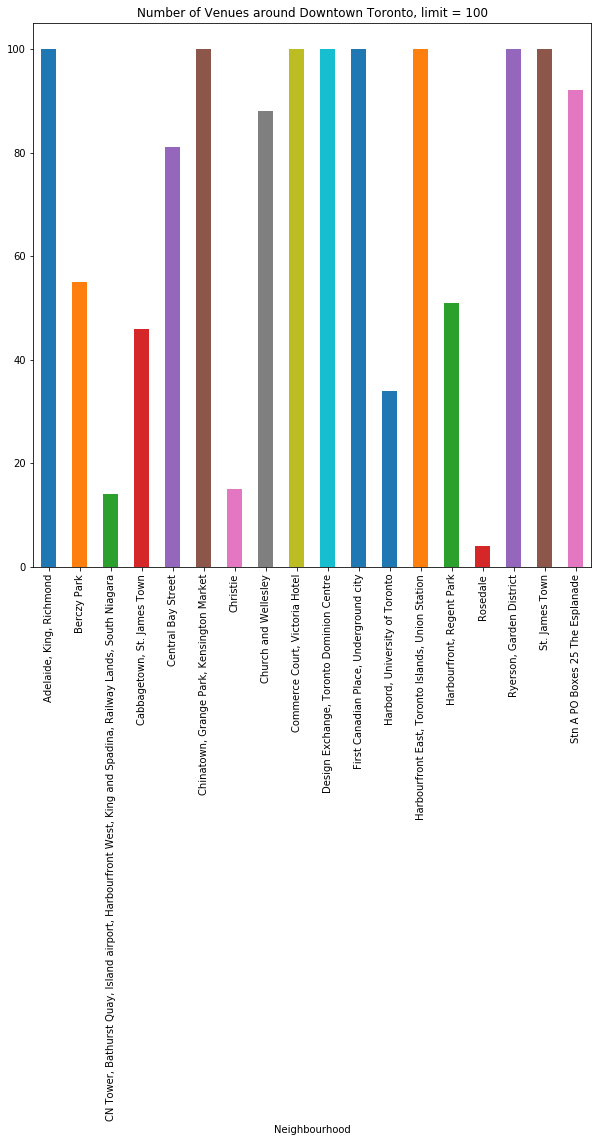

In [14]:
temp = downtown_toronto_venues.groupby('Neighbourhood').count()
temp["Venue"].plot(kind = "bar", 
                figsize = (10, 10), 
                title = "Number of Venues around Downtown Toronto, limit = 100")

In [15]:
print('There are {} uniques categories.'.format(len(downtown_toronto_venues['Venue Category'].unique())))

There are 203 uniques categories.


## Let us see which is the top venue category in Downtown Toronto area

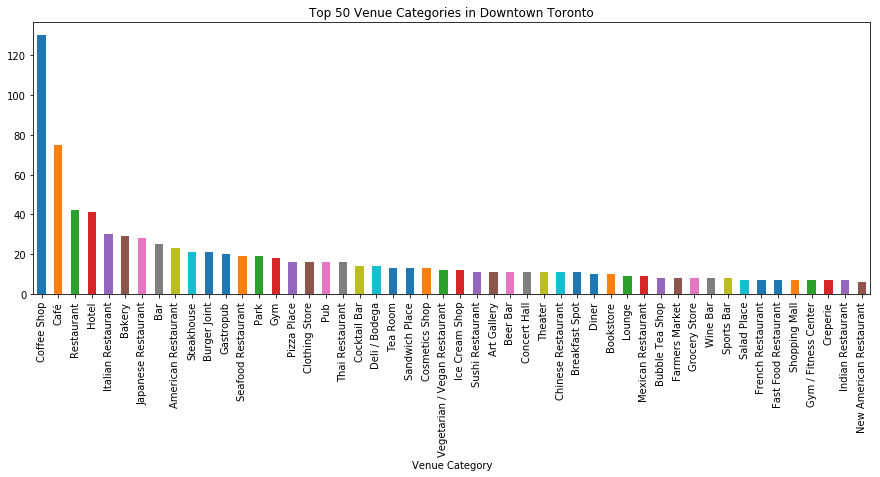

In [16]:
temp = downtown_toronto_venues.groupby("Venue Category").count()

#create a dataframe with top 50 venue categories by count
temp = temp.sort_values(by = ["Neighbourhood"], 
                        axis = 0, 
                        ascending = False).head(50)

#plot the top 50 venue categories
temp["Venue"].plot(kind = "bar", 
                   figsize = (15, 5), 
                   title = "Top 50 Venue Categories in Downtown Toronto")

In [17]:
# one hot encoding
downtown_toronto_onehot = pd.get_dummies(downtown_toronto_venues[['Venue Category']], 
                                         prefix="", 
                                         prefix_sep="")

# add neighborhood column back to dataframe
downtown_toronto_onehot['Neighbourhood'] = downtown_toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [downtown_toronto_onehot.columns[-1]] + list(downtown_toronto_onehot.columns[:-1])
downtown_toronto_onehot = downtown_toronto_onehot[fixed_columns]

downtown_toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#group by neighbourhood and calculate mean

downtown_toronto_grouped = downtown_toronto_onehot.groupby('Neighbourhood').mean().reset_index()
downtown_toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.00000,0.010000,0.000000,0.000000,0.010000,0.01,0.000000
1,Berczy Park,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.00,0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,...,0.00,0.00,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,"Cabbagetown, St. James Town",0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Central Bay Street,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.00000,0.012346,0.000000,0.000000,0.012346,0.00,0.012346
5,"Chinatown, Grange Park, Kensington Market",0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.01,0.01,0.00,0.00000,0.060000,0.000000,0.040000,0.010000,0.00,0.000000
6,Christie,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
7,Church and Wellesley,0.00,0.011364,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.00000,0.011364,0.011364,0.011364,0.000000,0.00,0.011364
8,"Commerce Court, Victoria Hotel",0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.00000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000
9,"Design Exchange, Toronto Dominion Centre",0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.01000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000


### Print each neighborhood along with the top 5 most common venues

In [19]:
num_top_venues = 5

for hood in downtown_toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = downtown_toronto_grouped[downtown_toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.06
2           Steakhouse  0.04
3  American Restaurant  0.04
4      Thai Restaurant  0.04


----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.05
2          Café  0.04
3   Cheese Shop  0.04
4    Steakhouse  0.04


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.14
1  Airport Terminal  0.14
2   Airport Service  0.14
3          Boutique  0.07
4  Sculpture Garden  0.07


----Cabbagetown, St. James Town----
         venue  freq
0  Coffee Shop  0.09
1   Restaurant  0.09
2       Bakery  0.04
3       Market  0.04
4          Pub  0.04


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.15
1                 Café  0.07
2   Italian Restaurant  0.05
3         Burger Joint  0.04
4  Japanese Restaurant  0.04

### Create a new dataframe to display top 10 venues for each neighborhood.

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns = columns)
neighbourhoods_venues_sorted['Neighbourhood'] = downtown_toronto_grouped['Neighbourhood']

for ind in np.arange(downtown_toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_toronto_grouped.iloc[ind, :], 
                                                                           num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,American Restaurant,Restaurant,Bar,Hotel,Cosmetics Shop,Gym
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Restaurant,Beer Bar,Seafood Restaurant,Farmers Market,Bakery,Cheese Shop,Café
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Airport Service,Harbor / Marina,Sculpture Garden,Boutique,Boat or Ferry,Plane,Airport Gate,Airport
3,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Pub,Indian Restaurant,Italian Restaurant,Bakery,Pizza Place,Market,Café,Park
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Bar,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Ice Cream Shop,Falafel Restaurant
5,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Bar,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Dumpling Restaurant,Grocery Store
6,Christie,Grocery Store,Café,Park,Baby Store,Italian Restaurant,Diner,Nightclub,Convenience Store,Restaurant,Coffee Shop
7,Church and Wellesley,Japanese Restaurant,Coffee Shop,Burger Joint,Gay Bar,Sushi Restaurant,Restaurant,Mediterranean Restaurant,Men's Store,Pub,Café
8,"Commerce Court, Victoria Hotel",Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Italian Restaurant,Deli / Bodega,Gastropub,Steakhouse,Gym
9,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Hotel,Café,American Restaurant,Deli / Bodega,Gastropub,Restaurant,Sports Bar,Gym,Italian Restaurant


## K-Means Clustering (clusters = 5)

In [22]:
# set number of clusters
kclusters = 5

downtown_toronto_grouped_clustering = downtown_toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, 
                random_state = 0).fit(downtown_toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 3, 4, 0, 0, 0])

In [23]:
downtown_toronto_merged = downtown_toronto_df

# add clustering labels
downtown_toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
downtown_toronto_merged = downtown_toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), 
                                                       on = 'Neighbourhood')

downtown_toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Park,Playground,Trail,Department Store,Ethiopian Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,0,Coffee Shop,Restaurant,Pub,Indian Restaurant,Italian Restaurant,Bakery,Pizza Place,Market,Café,Park
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,2,Japanese Restaurant,Coffee Shop,Burger Joint,Gay Bar,Sushi Restaurant,Restaurant,Mediterranean Restaurant,Men's Store,Pub,Café
3,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Café,Mexican Restaurant,Breakfast Spot,Restaurant,Pub,Theater,Brewery
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Bar,Japanese Restaurant,Pizza Place,Tea Room,Middle Eastern Restaurant,Italian Restaurant


In [24]:
# create map
map_clusters = folium.Map(location = [downtown_toronto_lat, downtown_toronto_long], zoom_start = 13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_toronto_merged['Latitude'], 
                                  downtown_toronto_merged['Longitude'], 
                                  downtown_toronto_merged['Neighbourhood'], 
                                  downtown_toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 7,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

## Examining Clusters

## Cluster 0

### This cluster is a perfect mixture for different venue categories. Most common venue in this cluster is a coffee shop followed by cafe. There are a lots of restaurants and fast food joints. It also has many options for recreational activities like pubs, nightclubs and parks.

In [25]:
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 0, 
                            downtown_toronto_merged.columns[[2] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rosedale,0,Park,Playground,Trail,Department Store,Ethiopian Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
1,"Cabbagetown, St. James Town",0,Coffee Shop,Restaurant,Pub,Indian Restaurant,Italian Restaurant,Bakery,Pizza Place,Market,Café,Park
3,"Harbourfront, Regent Park",0,Coffee Shop,Bakery,Park,Café,Mexican Restaurant,Breakfast Spot,Restaurant,Pub,Theater,Brewery
4,"Ryerson, Garden District",0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Bar,Japanese Restaurant,Pizza Place,Tea Room,Middle Eastern Restaurant,Italian Restaurant
7,Central Bay Street,0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Bar,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Ice Cream Shop,Falafel Restaurant
8,"Adelaide, King, Richmond",0,Coffee Shop,Café,Thai Restaurant,Steakhouse,American Restaurant,Restaurant,Bar,Hotel,Cosmetics Shop,Gym
9,"Harbourfront East, Toronto Islands, Union Station",0,Coffee Shop,Hotel,Aquarium,Pizza Place,Café,Scenic Lookout,Italian Restaurant,Brewery,Sports Bar,Park
10,"Design Exchange, Toronto Dominion Centre",0,Coffee Shop,Hotel,Café,American Restaurant,Deli / Bodega,Gastropub,Restaurant,Sports Bar,Gym,Italian Restaurant
12,"Harbord, University of Toronto",0,Café,Bar,Japanese Restaurant,Bakery,Restaurant,Coffee Shop,Bookstore,Pub,Jazz Club,Beer Bar
13,"Chinatown, Grange Park, Kensington Market",0,Café,Vegetarian / Vegan Restaurant,Bar,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Dumpling Restaurant,Grocery Store


## Cluster 1

### This cluster seems to in the vicinity of an airport as there are Airport services available around this area.

In [26]:
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 1, 
                            downtown_toronto_merged.columns[[2] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"CN Tower, Bathurst Quay, Island airport, Harbo...",1,Airport Lounge,Airport Terminal,Airport Service,Harbor / Marina,Sculpture Garden,Boutique,Boat or Ferry,Plane,Airport Gate,Airport


## Cluster 2

### Church and Wellesley neighbourhood has eateries and men's shops.

In [27]:
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 2, 
                            downtown_toronto_merged.columns[[2] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Church and Wellesley,2,Japanese Restaurant,Coffee Shop,Burger Joint,Gay Bar,Sushi Restaurant,Restaurant,Mediterranean Restaurant,Men's Store,Pub,Café


## Cluster 3

### This cluster is similar to Cluster 0.  This cluster also hosts several hotels.

In [28]:
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 3, 
                            downtown_toronto_merged.columns[[2] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,St. James Town,3,Coffee Shop,Café,Restaurant,Clothing Store,Hotel,Cocktail Bar,Gastropub,Bakery,Italian Restaurant,Cosmetics Shop
11,"Commerce Court, Victoria Hotel",3,Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Italian Restaurant,Deli / Bodega,Gastropub,Steakhouse,Gym


## Cluster 4

### Berczy Park area is an ideal food joint with many eateries and a Beer bar.

In [29]:
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 4, 
                            downtown_toronto_merged.columns[[2] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Berczy Park,4,Coffee Shop,Cocktail Bar,Steakhouse,Restaurant,Beer Bar,Seafood Restaurant,Farmers Market,Bakery,Cheese Shop,Café
